# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
!pip install pyLDAvis

In [2]:
# Write your code here
import pandas as pd
import nltk
# NLTK Stop words
from nltk.corpus import stopwords
from textblob import Word
nltk.download('wordnet')
from nltk.stem import PorterStemmer
st = PorterStemmer()
# spacy for lemmatization
import spacy
import re
import numpy as np
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df = pd.read_csv('/content/titles.csv')
df.head()

,Titles
0,Foundations of statistical natural language pr...
1,Natural language processing with Python: analy...
2,The Stanford CoreNLP natural language processi...
3,Handbook of natural language processing
4,Natural language processing (almost) from scratch


In [4]:
# Write your code here

#1 Noise removal
df['Titles'] = df['Titles'].replace('\n','',regex = True)
df['Titles'] = df['Titles'].replace('[^\w\s]','',regex = True)

#2 Remove numbers
df['Titles'] = df['Titles'].str.replace('\d+','')
df['Titles'] = df['Titles'].str.replace('\d+','')
#3 Remove StopWords
stop_Words = ["i", "me", "my", "myself", "we", "our", "ours", 
              "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her",
              "hers", "herself", "it", "its", "itself", "they", "them",
              "their", "theirs", "themselves", "what", "which", "who",
              "whom", "this", "that", "these", "those", "am", "is",
              "are", "was", "were", "be", "been", "being", "have",
              "has", "had", "having", "do", "does", "did", "doing",
              "a", "an", "the", "and", "but", "if", "or", "because",
              "as", "until", "while", "of", "at", "by", "for", "with",
              "about", "against", "between", "into", "through",
              "during", "before", "after", "above", "below", "to",
              "from", "up", "down", "in", "out", "on", "off", "over",
              "under", "again", "further", "then", "once", "here",
              "there", "when", "where", "why", "how", "all", "any",
              "both", "each", "few", "more", "most", "other", "some",
              "such", "no", "nor", "not", "only", "own", "same", "so",
              "than", "too", "very", "s", "t", "can", "will", "just",
              "don", "should", "now"]
# stop = stopwords.words('english')
df['Titles'] = df['Titles'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_Words))
#4 Lowercase all text
df['Titles'] = df['Titles'].str.lower()
#5 Stemming
df['Titles'] = df['Titles'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#6 Lemmatization
df['Titles']=df['Titles'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [5]:
df.head()

,Titles
0,foundat statist natur languag process
1,natur languag process python analyz text natur...
2,the stanford corenlp natur languag process too...
3,handbook natur languag process
4,natur languag process almost scratch


In [6]:
data = df.Titles.values.tolist()

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['foundat', 'statist', 'natur', 'languag', 'process']]


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=2) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=2)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example

print(trigram_mod[bigram_mod[data_words[1]]])

['natur_languag_process', 'python', 'analyz', 'text', 'natur_languag', 'toolkit']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
  """https://spacy.io/api/annotation"""
  texts_out = []
  for sent in texts:
      doc = nlp(" ".join(sent)) 
      texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
  return texts_out

In [10]:
data_words_trigrams = make_trigrams(data_words)
data_words_bigrams = make_bigrams(data_words)

In [11]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])


In [12]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_trigrams = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_bigrams = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized_bigrams[:10])

[['process'], ['process', 'text', 'toolkit'], ['corenlp', 'process', 'toolkit'], ['process'], ['process', 'almost', 'scratch'], ['approach', 'process'], ['process'], ['read', 'process'], ['recent', 'trend', 'deep', 'learn', 'base', 'process'], ['process', 'deep', 'neural', 'network', 'multitask', 'learn']]


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized_bigrams)

# Create Corpus
texts = data_lemmatized_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [14]:
id2word[0]

'process'

In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]

[[('process', 1)],
 [('process', 1), ('text', 1), ('toolkit', 1)],
 [('process', 1), ('toolkit', 1), ('corenlp', 1)],
 [('process', 1)],
 [('process', 1), ('almost', 1), ('scratch', 1)],
 [('process', 1), ('approach', 1)],
 [('process', 1)],
 [('process', 1), ('read', 1)],
 [('process', 1),
  ('base', 1),
  ('deep', 1),
  ('learn', 1),
  ('recent', 1),
  ('trend', 1)],
 [('process', 1),
  ('deep', 1),
  ('learn', 1),
  ('multitask', 1),
  ('network', 1),
  ('neural', 1)]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=100, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(11,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (36,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (87,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (9,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (75,
  '0.008*"related" + 0.008*"modular" + 0.008*"thereof" + 0.008*"comput" + '
  '0.008*"handbook" + 0.008*"linguist" + 0.008*"medicin" + 0.008*"kind" + '
  '0.008*"record" + 0.008*"problem"'),
 (13,
  '0.008*"

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.498916633654295

Coherence Score:  0.6806093326364346


In [19]:
# Visualize the topics
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
89    -0.136293  0.298384       1        1  4.112397
60    -0.356289 -0.006825       2        1  3.675375
2     -0.213833  0.290073       3        1  3.244261
57     0.218162  0.326261       4        1  3.214141
42    -0.064422  0.375580       5        1  3.198078
...         ...       ...     ...      ...       ...
56     0.016602 -0.142358      96        1  0.205696
58     0.016602 -0.142358      97        1  0.205696
59     0.016602 -0.142358      98        1  0.205696
61     0.016602 -0.142358      99        1  0.205696
0      0.016602 -0.142358     100        1  0.205696

[100 rows x 5 columns], topic_info=        Term       Freq      Total  Category  logprob  loglift
0    process  74.000000  74.000000   Default  30.0000  30.0000
44    system  13.000000  13.000000   Default  29.0000  29.0000
19       use   8.000000   8.000000   Default  28.0000  

In [20]:
!pip install smart_open 

In [21]:
help('smart_open')

Help on package smart_open:

NAME
    smart_open

DESCRIPTION
    Utilities for streaming to/from several file-like data storages: S3 / HDFS / local
    filesystem / compressed files, and many more, using a simple, Pythonic API.
    
    The streaming makes heavy use of generators and pipes, to avoid loading
    full file contents into memory, allowing work with arbitrarily large files.
    
    The main functions are:
    
    * `open()`, which opens the given file for reading/writing
    * `parse_uri()`
    * `s3_iter_bucket()`, which goes over all keys in an S3 bucket in parallel
    * `register_compressor()`, which registers callbacks for transparent compressor handling

PACKAGE CONTENTS
    azure
    bytebuffer
    compression
    concurrency
    constants
    doctools
    gcs
    hdfs
    http
    local_file
    s3
    smart_open_lib
    ssh
    tests (package)
    transport
    utils
    version
    webhdfs

FUNCTIONS
    open(uri, mode='r', buffering=-1, encoding=None, errors=N

In [22]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

--2020-10-23 01:55:11--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.1’

mallet-2.0.8.zip.1  100%[===================>]  15.43M  8.98MB/s    in 1.7s    

2020-10-23 01:55:13 (8.98 MB/s) - ‘mallet-2.0.8.zip.1’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [27]:
import os
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=100, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [28]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized_bigrams, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(79,
  [('user', 0.6666666666666666),
   ('process', 0.3333333333333333),
   ('related', 0.0),
   ('thereof', 0.0),
   ('comput', 0.0),
   ('handbook', 0.0),
   ('linguist', 0.0),
   ('medicin', 0.0),
   ('predict', 0.0),
   ('problem', 0.0)]),
 (3,
  [('report', 1.0),
   ('modular', 0.0),
   ('postop', 0.0),
   ('comput', 0.0),
   ('handbook', 0.0),
   ('linguist', 0.0),
   ('medicin', 0.0),
   ('related', 0.0),
   ('predict', 0.0),
   ('answer', 0.0)]),
 (27,
  [('process', 0.8),
   ('input', 0.2),
   ('related', 0.0),
   ('postop', 0.0),
   ('comput', 0.0),
   ('handbook', 0.0),
   ('linguist', 0.0),
   ('medicin', 0.0),
   ('predict', 0.0),
   ('modular', 0.0)]),
 (73,
  [('process', 0.875),
   ('deep', 0.125),
   ('pdp', 0.0),
   ('comput', 0.0),
   ('handbook', 0.0),
   ('linguist', 0.0),
   ('medicin', 0.0),
   ('related', 0.0),
   ('predict', 0.0),
   ('problem', 0.0)]),
 (99,
  [('retriev', 0.6666666666666666),
   ('convolut', 0.3333333333333333),
   ('modular', 0.0),
   ('co

/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]



Coherence Score:  0.710532092538672


In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [35]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized_bigrams, start=2, limit=100, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/wrappers/ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


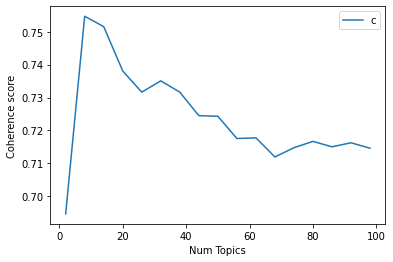

In [36]:
# Show graph
limit=100; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [37]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6946
Num Topics = 8  has Coherence Value of 0.7547
Num Topics = 14  has Coherence Value of 0.7515
Num Topics = 20  has Coherence Value of 0.7381
Num Topics = 26  has Coherence Value of 0.7316
Num Topics = 32  has Coherence Value of 0.7351
Num Topics = 38  has Coherence Value of 0.7316
Num Topics = 44  has Coherence Value of 0.7245
Num Topics = 50  has Coherence Value of 0.7243
Num Topics = 56  has Coherence Value of 0.7175
Num Topics = 62  has Coherence Value of 0.7178
Num Topics = 68  has Coherence Value of 0.7119
Num Topics = 74  has Coherence Value of 0.7148
Num Topics = 80  has Coherence Value of 0.7167
Num Topics = 86  has Coherence Value of 0.715
Num Topics = 92  has Coherence Value of 0.7162
Num Topics = 98  has Coherence Value of 0.7146


In [38]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.364*"neural" + 0.091*"account" + 0.091*"input" + 0.091*"rank" + '
  '0.091*"weather" + 0.091*"vector" + 0.091*"convolut" + 0.091*"prolog" + '
  '0.000*"handbook" + 0.000*"linguist"'),
 (1,
  '0.769*"process" + 0.154*"user" + 0.077*"case" + 0.000*"modular" + '
  '0.000*"pdp" + 0.000*"handbook" + 0.000*"linguist" + 0.000*"medicin" + '
  '0.000*"related" + 0.000*"thereof"'),
 (2,
  '0.353*"method" + 0.059*"detect" + 0.059*"geni" + 0.059*"rescu" + '
  '0.059*"structur" + 0.059*"overview" + 0.059*"requir" + 0.059*"analysi" + '
  '0.059*"input" + 0.059*"paninian"'),
 (3,
  '0.357*"process" + 0.071*"medic" + 0.071*"deep" + 0.071*"comput" + '
  '0.071*"platform" + 0.071*"system" + 0.071*"predict" + 0.071*"drama" + '
  '0.071*"mine" + 0.071*"situat"'),
 (4,
  '0.222*"semant" + 0.056*"space" + 0.056*"radiolog" + 0.056*"transfer" + '
  '0.056*"jump" + 0.056*"record" + 0.056*"inform" + 0.056*"molecular" + '
  '0.056*"strategi" + 0.056*"maximum"'),
 (5,
  '0.222*"review" + 0.167*"speech" 

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [25]:
# Write your code here



## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [26]:
# Write your answer here (no code needed for this question)